In [2]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import matplotlib.pyplot as plt

class Island:
    def __init__(self, xcentr=5, ycentr=5, radius=1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5 - self.radius

    def draw_island(self, color='blue'):
        return plt.Circle((self.xcentr, self.ycentr), self.radius, color=color)

    def getCoords(self):
        return [self.xcentr, self.ycentr]


In [4]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class Ship:
    def __init__(self, x = 1, y = 5, v = 1, direction = 0):
        self.x = x
        self.y = y
        self.v = v
        self.direction = direction
        self.prev_d = self.direction
        self.positions = [[self.x, self.y]]
        self.cum_d = 0
        
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)
        self.cum_d += abs(self.direction - self.prev_d)
        self.prev_d = self.direction
        
    def getCoords(self):
        return [self.x, self.y]
    
    def add_position(self):
        self.positions.append([self.x, self.y])
        
    def get_positions(self):
        return self.positions

In [257]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['left', 'right', 'idle']
        self.n_actions = len(self.action_space)
        self.n_features = 2

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}
        
        self.prev_dist = 0
        self.prev_i_dist = 0
        self.n_angles = 0

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0
        
    def get_state(self):
        a = self.ship.getCoords()
        b = self.island.getCoords()
        c = self.flag.getCoords()
        dxi, dyi = b[0] - a[0], b[1] - a[1]
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        i_angle = math.atan2(dyi, dxi)
        return [f_angle - self.ship.direction, self.island.get_dist(a[0], a[1]), i_angle - self.ship.direction, self.flag.get_dist(a[0], a[1])]

    def build_environment(self):
        self.n_angles = 0
        rate = random.uniform(0.4, 0.6)
        dist = random.uniform(7, 15)
        angle = random.uniform(0, 2*math.pi)
        self.flag = Island(0, 0, 1)
        self.ship = Ship(dist * math.cos(angle), dist * math.sin(angle))
        self.island = Island(rate * dist * math.cos(angle), rate * dist * math.sin(angle))
        a = self.ship.getCoords()
        c = self.flag.getCoords()
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        self.ship.direction = f_angle
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.island.get_dist(self.ship.x, self.ship.y)
    
    def reset(self):
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.get_state()
    
    def step(self, action):
        dt = 1
        
        state = self.ship.getCoords()

        if action == 0:
            self.ship.direction += math.pi / 6
            self.n_angles += 1
        elif action == 1:
            self.ship.direction -= math.pi / 6
            self.n_angles += 1
        # elif action == 2:
        #     self.ship.v += 0.25
        # elif action == 3:
        #     self.ship.v -= 0.25
        
        self.ship.move(dt)
        
        self.ship.add_position()

        next_state = self.get_state()

        self.i += 1
        
        if self.flag.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = 20000
            done = True
            
            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500

        elif self.island.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = -10000
            done = True

            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500
            
        elif len(self.ship.get_positions()) > 25:
            done = True
            self.d = {}
            self.i = 0
            # print("Time limit exceeded")
            reward = -1000 * (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 2
            reward -= self.n_angles * 500

        else:
            reward = (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 3
            reward -= 0.1 * (self.prev_i_dist - self.island.get_dist(self.ship.x, self.ship.y)) ** 3
            if reward < 0:
                reward *= 10
            # reward += 10 * (1 - self.ship.cum_d ** 2) * math.exp( - 0.5 * self.ship.cum_d ** 2) - 5
            done = False
        
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.island.get_dist(self.ship.x, self.ship.y)

        return next_state, reward, done 
    
    def draw_map(self):
        field, ax = plt.subplots()
        ax.set(xlim=(x_upper_bound * -2, x_upper_bound * 2), ylim=(y_upper_bound * -2, y_upper_bound * 2))
        ax.set_aspect(1)
        ax.add_artist(self.island.draw_island('green'))
        ax.add_artist(self.flag.draw_island())
        pos = self.ship.get_positions()
        for i in range(len(pos) - 1):
            ax.plot([pos[i][0], pos[i + 1][0]], [pos[i][1], pos[i + 1][1]], marker = 'o', color='r')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()

Ключевая идея: подаем на вектор относительных координат острова и флага, а также пеленги на них.

In [258]:
BATCH_SIZE = 100
LR = 0.03
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = 4
EPISODES = 200000

In [259]:
from torch.autograd import Variable 
class LSTM1(nn.Module):
    def __init__(self, num_classes=NUM_ACTIONS,
                 input_size=NUM_STATES,
                 hidden_size=NUM_STATES-2,
                 num_layers=2):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, x):
        # h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [260]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, 160)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(160, 80)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(80, NUM_ACTIONS)
        self.fc4.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [261]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [262]:
class DQN():
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()
        
    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1
        
    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action
    
    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|                                                                                       | 0/200000 [00:00<?, ?it/s]

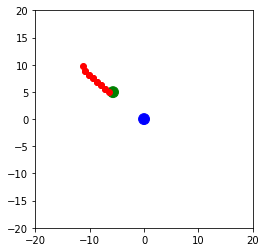

  0%|▎                                                                         | 1000/200000 [00:10<1:01:40, 53.77it/s]

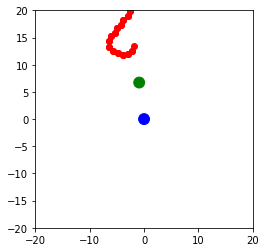

  1%|▊                                                                           | 1997/200000 [00:28<55:27, 59.50it/s]

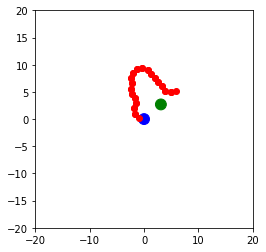

  1%|█▏                                                                          | 2993/200000 [00:43<40:33, 80.96it/s]

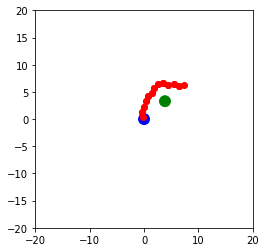

  2%|█▌                                                                          | 3999/200000 [00:55<37:07, 87.99it/s]

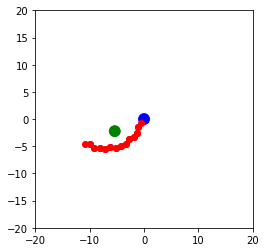

  2%|█▉                                                                          | 4991/200000 [01:06<32:59, 98.54it/s]

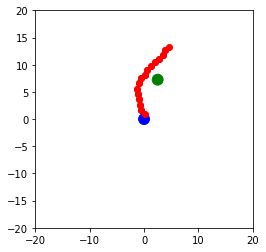

  3%|██▎                                                                         | 5999/200000 [01:17<37:49, 85.50it/s]

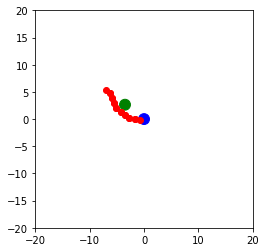

  3%|██▋                                                                         | 6993/200000 [01:28<37:15, 86.32it/s]

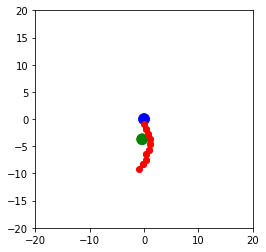

  4%|███                                                                         | 7992/200000 [01:39<36:09, 88.51it/s]

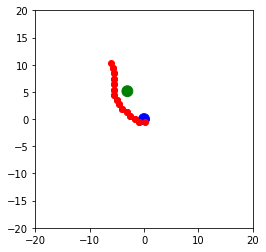

  4%|███▍                                                                        | 9000/200000 [01:51<38:54, 81.82it/s]

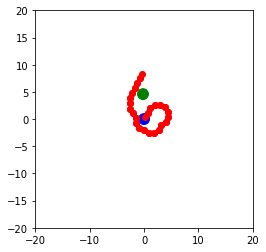

  5%|███▊                                                                        | 9997/200000 [02:03<37:53, 83.57it/s]

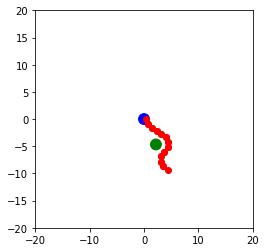

  5%|████                                                                       | 10996/200000 [02:15<38:48, 81.17it/s]

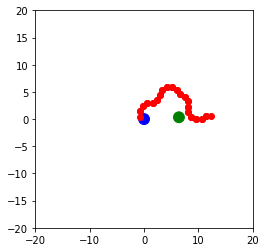

  6%|████▍                                                                      | 11993/200000 [02:27<37:43, 83.06it/s]

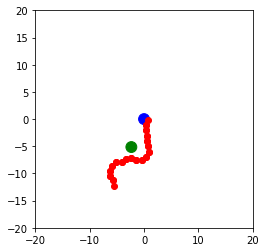

  6%|████▊                                                                      | 12993/200000 [02:38<33:34, 92.83it/s]

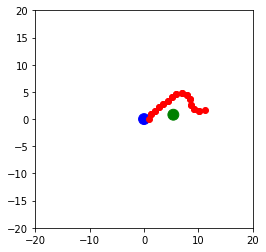

  7%|█████▏                                                                     | 13999/200000 [02:50<31:56, 97.07it/s]

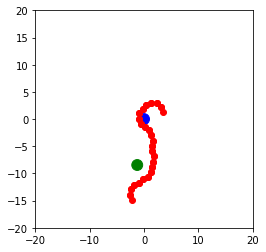

  7%|█████▌                                                                     | 14996/200000 [03:01<32:13, 95.68it/s]

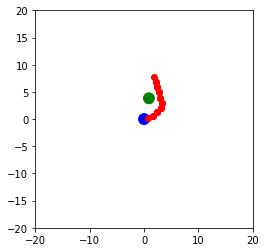

  8%|█████▉                                                                    | 15996/200000 [03:11<28:57, 105.87it/s]

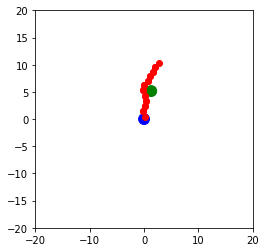

  8%|██████▎                                                                    | 16993/200000 [03:21<33:20, 91.50it/s]

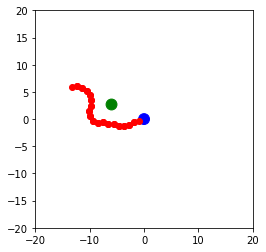

  9%|██████▋                                                                    | 17994/200000 [03:32<31:49, 95.32it/s]

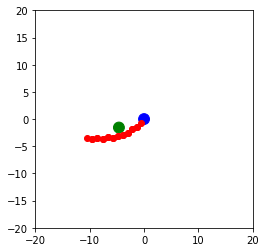

  9%|███████                                                                    | 18996/200000 [03:42<30:45, 98.06it/s]

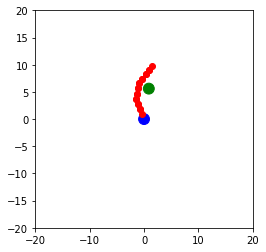

 10%|███████▍                                                                  | 19992/200000 [03:53<29:54, 100.28it/s]

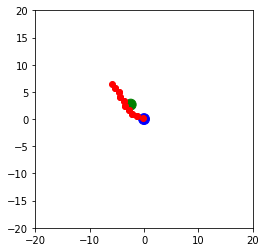

 10%|███████▊                                                                   | 20994/200000 [04:03<32:32, 91.69it/s]

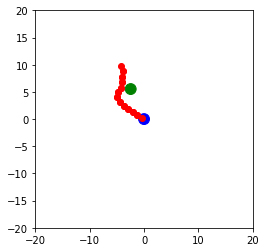

 11%|████████▏                                                                  | 21999/200000 [04:13<30:45, 96.45it/s]

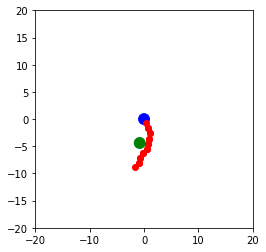

 11%|████████▌                                                                 | 22999/200000 [04:23<28:52, 102.14it/s]

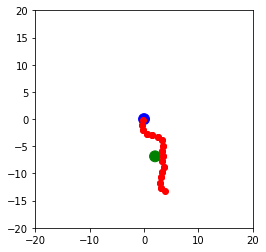

 12%|████████▉                                                                 | 23992/200000 [04:33<27:20, 107.27it/s]

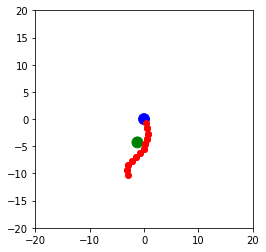

 12%|█████████▎                                                                 | 24994/200000 [04:43<31:44, 91.91it/s]

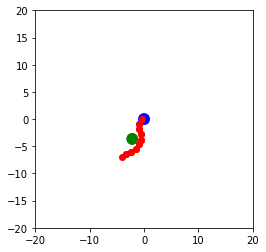

 13%|█████████▋                                                                 | 25994/200000 [04:54<31:49, 91.12it/s]

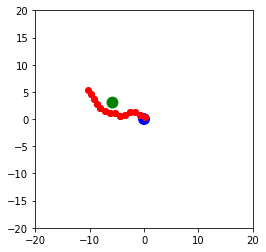

 13%|██████████                                                                 | 26993/200000 [05:05<29:49, 96.65it/s]

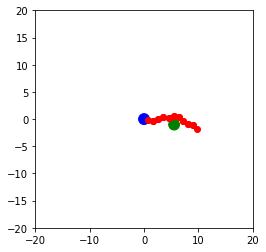

 14%|██████████▎                                                               | 27990/200000 [05:15<28:31, 100.52it/s]

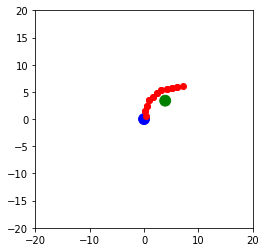

 14%|██████████▋                                                               | 28996/200000 [05:25<28:10, 101.15it/s]

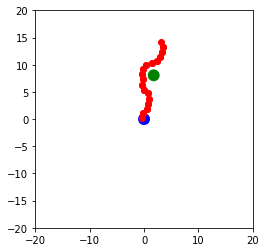

 15%|███████████▏                                                               | 29996/200000 [05:36<29:08, 97.25it/s]

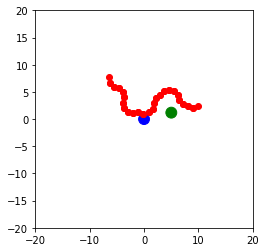

 15%|███████████▌                                                               | 30999/200000 [05:46<29:12, 96.45it/s]

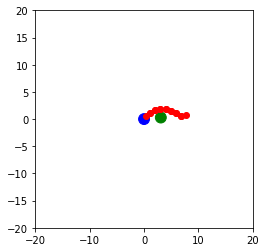

 16%|███████████▉                                                               | 31994/200000 [05:57<30:42, 91.20it/s]

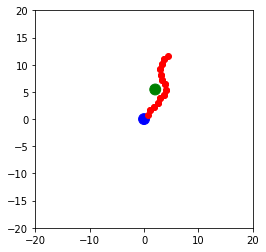

 16%|████████████▎                                                              | 32997/200000 [06:08<28:56, 96.18it/s]

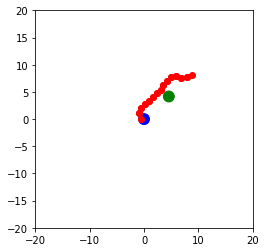

 17%|████████████▌                                                             | 33996/200000 [06:18<26:48, 103.21it/s]

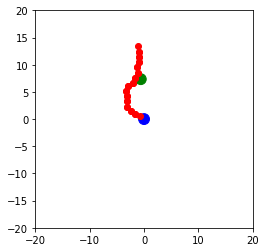

 17%|█████████████                                                              | 34993/200000 [06:29<30:21, 90.60it/s]

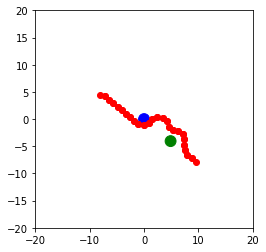

 18%|█████████████▍                                                             | 35995/200000 [06:39<29:52, 91.49it/s]

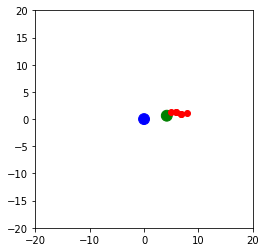

 18%|█████████████▊                                                             | 36992/200000 [06:49<28:43, 94.60it/s]

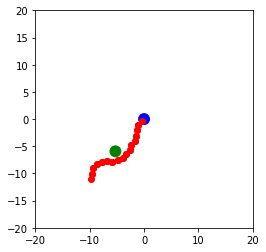

 19%|██████████████                                                            | 37997/200000 [07:00<26:31, 101.81it/s]

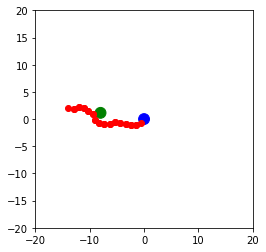

 20%|██████████████▍                                                           | 39000/200000 [07:10<26:39, 100.65it/s]

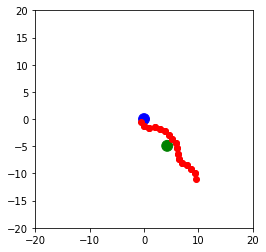

 20%|██████████████▊                                                           | 39994/200000 [07:20<26:18, 101.34it/s]

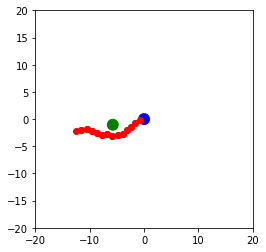

 20%|███████████████▎                                                           | 40995/200000 [07:30<27:51, 95.11it/s]

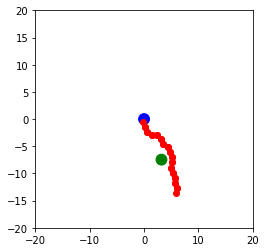

 21%|███████████████▌                                                          | 41992/200000 [07:40<24:39, 106.78it/s]

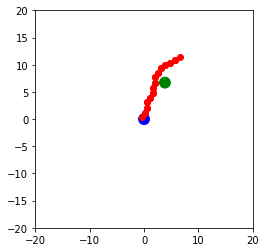

 21%|████████████████                                                           | 42994/200000 [07:50<26:34, 98.45it/s]

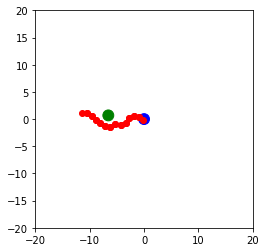

 22%|████████████████▍                                                          | 43992/200000 [08:00<26:38, 97.61it/s]

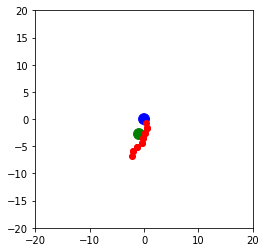

 22%|████████████████▋                                                         | 44994/200000 [08:10<24:26, 105.68it/s]

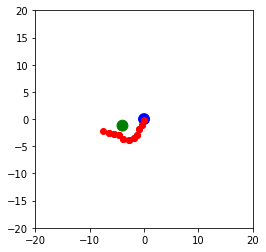

 23%|█████████████████▏                                                         | 45992/200000 [08:20<27:41, 92.71it/s]

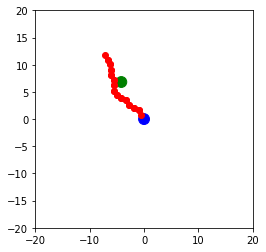

 23%|█████████████████▍                                                        | 46991/200000 [08:30<24:56, 102.27it/s]

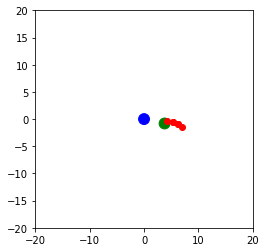

 24%|█████████████████▊                                                        | 47992/200000 [08:40<24:44, 102.42it/s]

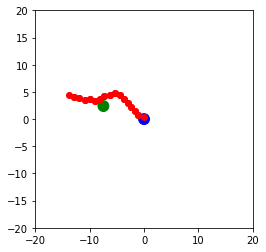

 24%|██████████████████▏                                                       | 48992/200000 [08:50<24:36, 102.27it/s]

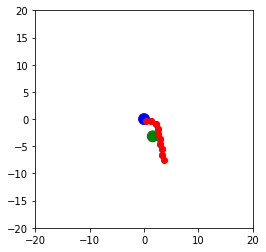

 25%|██████████████████▋                                                        | 49998/200000 [08:59<25:08, 99.44it/s]

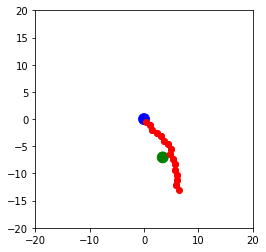

 25%|██████████████████▊                                                       | 50997/200000 [09:09<23:39, 104.96it/s]

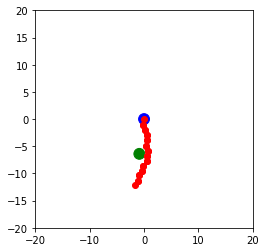

 26%|███████████████████▏                                                      | 51993/200000 [09:19<24:13, 101.80it/s]

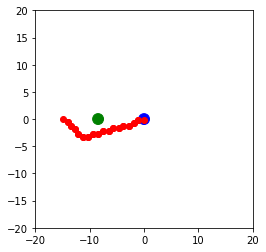

 26%|███████████████████▊                                                       | 52998/200000 [09:30<24:58, 98.10it/s]

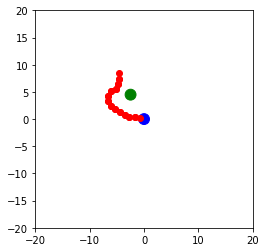

 27%|████████████████████▏                                                      | 53993/200000 [09:40<25:38, 94.93it/s]

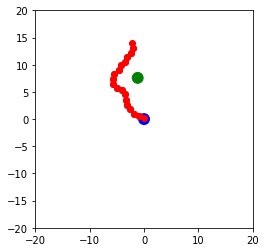

 27%|████████████████████▌                                                      | 54991/200000 [09:51<25:16, 95.60it/s]

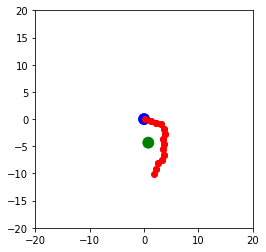

 28%|████████████████████▉                                                      | 55994/200000 [10:01<24:17, 98.82it/s]

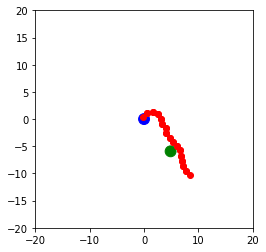

 28%|█████████████████████                                                     | 56994/200000 [10:11<23:07, 103.06it/s]

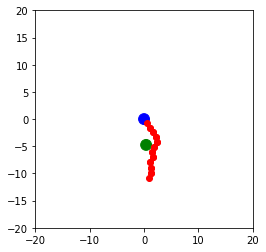

 29%|█████████████████████▍                                                    | 57997/200000 [10:21<22:51, 103.52it/s]

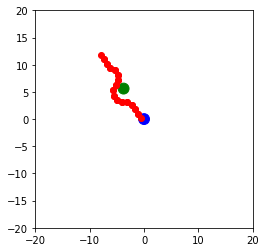

 29%|██████████████████████                                                     | 58993/200000 [10:31<24:08, 97.35it/s]

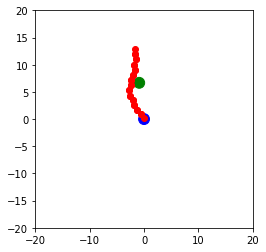

 30%|██████████████████████▏                                                   | 59989/200000 [10:41<23:14, 100.42it/s]

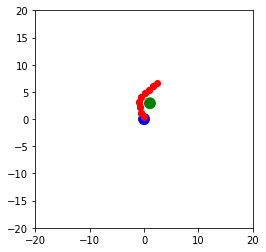

 30%|██████████████████████▉                                                    | 61000/200000 [10:52<25:15, 91.74it/s]

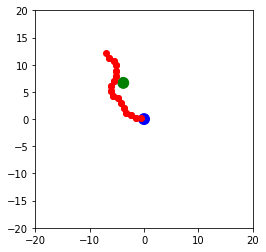

 31%|███████████████████████▏                                                   | 61999/200000 [11:03<24:28, 93.98it/s]

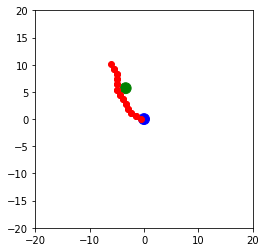

 31%|███████████████████████▌                                                   | 62990/200000 [11:13<25:09, 90.77it/s]

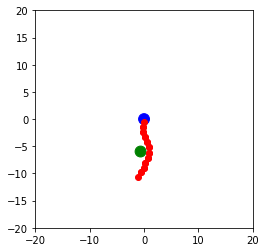

 32%|███████████████████████▋                                                  | 63996/200000 [11:23<21:59, 103.04it/s]

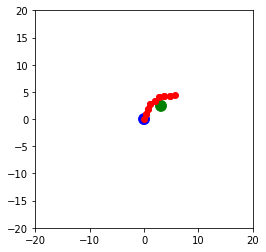

 32%|████████████████████████▎                                                  | 64999/200000 [11:34<24:48, 90.70it/s]

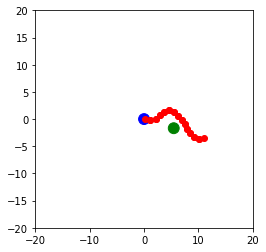

 33%|████████████████████████▋                                                  | 65999/200000 [11:44<25:00, 89.28it/s]

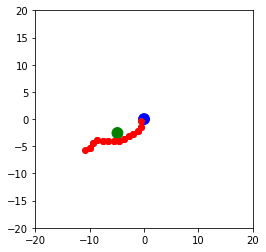

 33%|█████████████████████████                                                  | 66999/200000 [11:55<23:22, 94.81it/s]

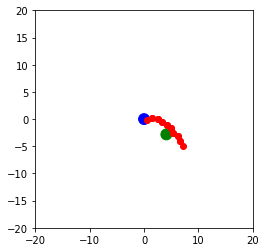

 34%|█████████████████████████▍                                                 | 67993/200000 [12:05<23:42, 92.80it/s]

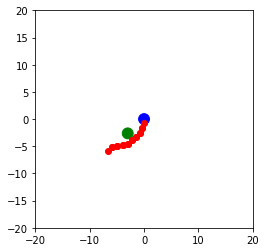

 34%|█████████████████████████▌                                                | 69000/200000 [12:16<21:36, 101.05it/s]

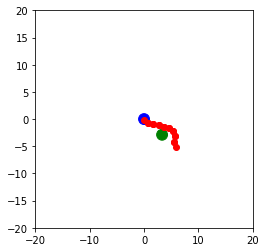

 35%|██████████████████████████▏                                                | 69993/200000 [12:26<22:10, 97.68it/s]

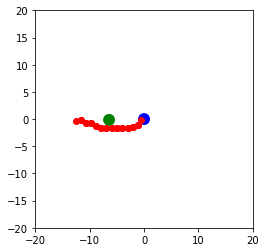

 35%|██████████████████████████▎                                               | 70999/200000 [12:36<19:58, 107.65it/s]

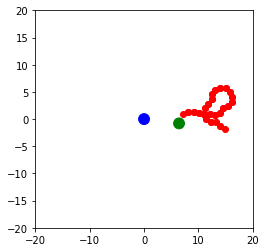

 36%|██████████████████████████▋                                               | 71996/200000 [12:46<20:58, 101.68it/s]

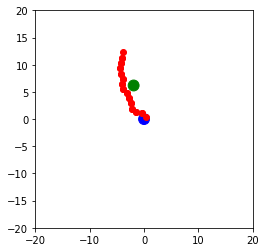

 36%|███████████████████████████                                               | 72998/200000 [12:57<20:28, 103.37it/s]

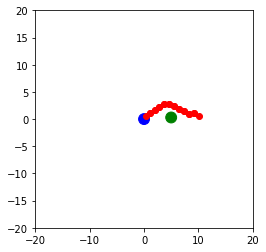

 37%|███████████████████████████▍                                              | 73995/200000 [13:07<20:32, 102.20it/s]

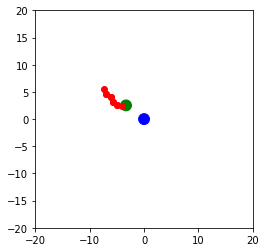

 37%|███████████████████████████▋                                              | 74991/200000 [13:17<20:40, 100.76it/s]

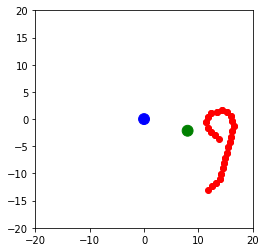

 38%|████████████████████████████                                              | 75994/200000 [13:27<20:24, 101.31it/s]

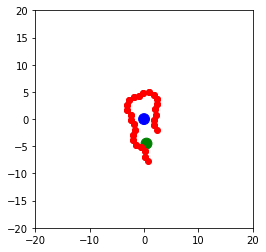

 38%|████████████████████████████▊                                              | 76990/200000 [13:37<21:53, 93.65it/s]

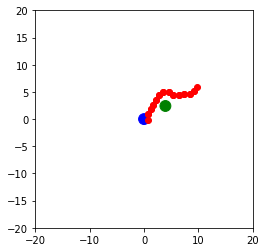

 39%|████████████████████████████▊                                             | 77996/200000 [13:47<19:47, 102.73it/s]

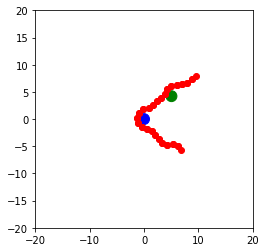

 39%|█████████████████████████████▌                                             | 78994/200000 [13:57<21:56, 91.93it/s]

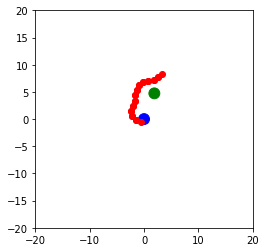

 40%|█████████████████████████████▉                                             | 79994/200000 [14:07<21:36, 92.59it/s]

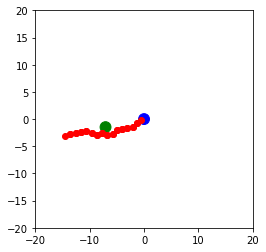

 40%|██████████████████████████████▎                                            | 80999/200000 [14:18<20:02, 98.99it/s]

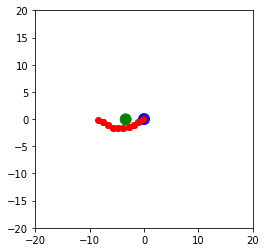

 41%|██████████████████████████████▋                                            | 81992/200000 [14:28<21:20, 92.18it/s]

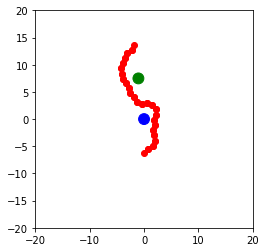

 41%|██████████████████████████████▋                                           | 82994/200000 [14:38<19:23, 100.58it/s]

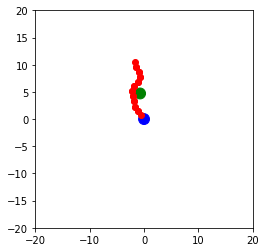

 42%|███████████████████████████████▍                                           | 83998/200000 [14:48<19:36, 98.57it/s]

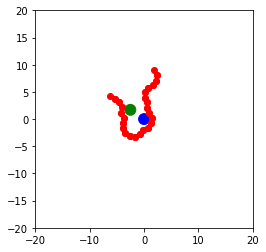

 42%|███████████████████████████████▊                                           | 84991/200000 [14:58<20:25, 93.86it/s]

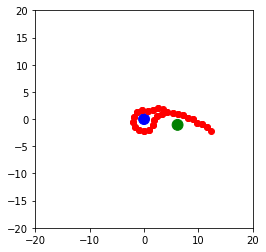

 43%|████████████████████████████████▏                                          | 85995/200000 [15:08<19:11, 98.99it/s]

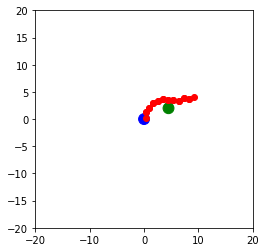

 44%|████████████████████████████████▋                                          | 87000/200000 [15:18<19:45, 95.30it/s]

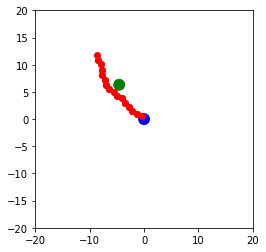

 44%|████████████████████████████████▉                                          | 87994/200000 [15:29<20:15, 92.18it/s]

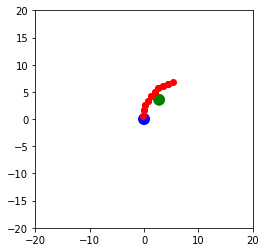

 44%|████████████████████████████████▉                                         | 88998/200000 [15:39<18:22, 100.66it/s]

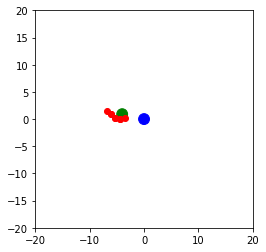

 45%|█████████████████████████████████▊                                         | 90000/200000 [15:49<18:20, 99.94it/s]

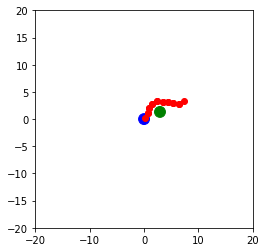

 45%|██████████████████████████████████                                         | 90993/200000 [15:59<21:24, 84.85it/s]

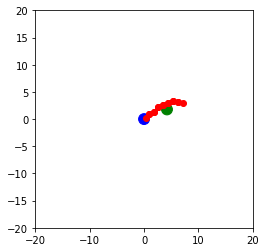

 46%|██████████████████████████████████▍                                        | 91995/200000 [16:10<18:39, 96.50it/s]

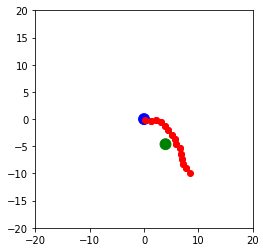

 46%|██████████████████████████████████▊                                        | 92997/200000 [16:20<18:01, 98.93it/s]

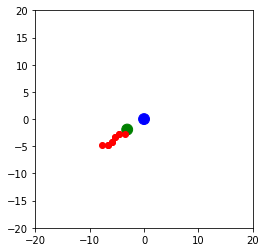

 47%|███████████████████████████████████▏                                       | 93998/200000 [16:30<18:09, 97.25it/s]

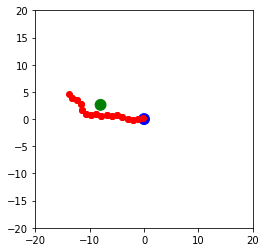

 47%|███████████████████████████████████▌                                       | 94994/200000 [16:40<18:41, 93.62it/s]

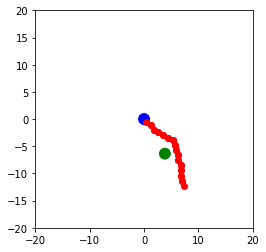

 48%|███████████████████████████████████▉                                       | 95992/200000 [16:51<18:48, 92.12it/s]

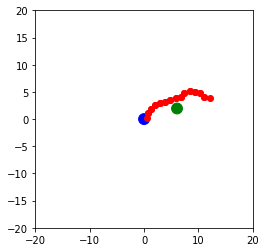

 48%|███████████████████████████████████▉                                      | 96994/200000 [17:01<16:27, 104.32it/s]

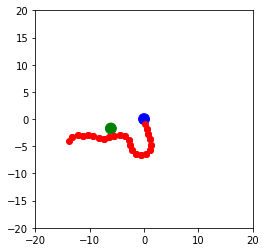

 49%|████████████████████████████████████▋                                      | 97992/200000 [17:12<18:19, 92.74it/s]

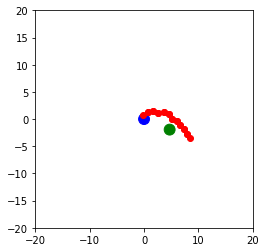

 49%|████████████████████████████████████▋                                     | 98993/200000 [17:22<16:33, 101.71it/s]

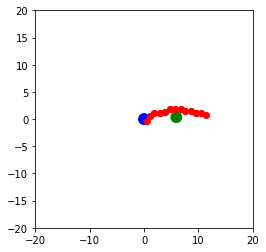

 50%|█████████████████████████████████████▍                                     | 99999/200000 [17:33<17:05, 97.51it/s]

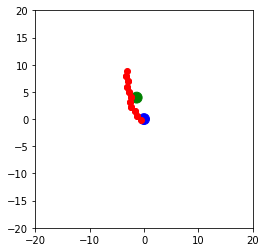

 50%|█████████████████████████████████████▎                                    | 101000/200000 [17:43<17:17, 95.38it/s]

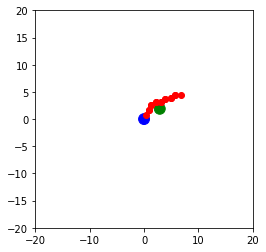

 51%|█████████████████████████████████████▋                                    | 101999/200000 [17:53<17:08, 95.30it/s]

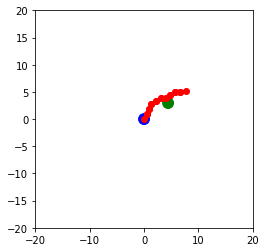

 51%|██████████████████████████████████████                                    | 102994/200000 [18:04<17:06, 94.50it/s]

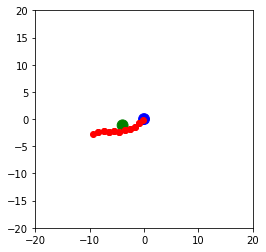

 52%|█████████████████████████████████████▉                                   | 103994/200000 [18:14<15:47, 101.37it/s]

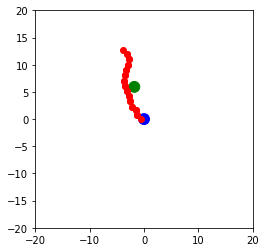

 52%|██████████████████████████████████████▎                                  | 104994/200000 [18:24<15:06, 104.86it/s]

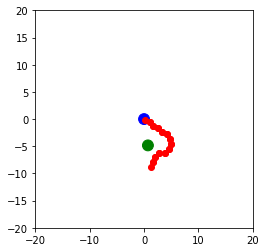

 53%|██████████████████████████████████████▋                                  | 106000/200000 [18:34<14:53, 105.17it/s]

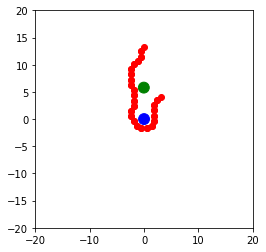

 54%|███████████████████████████████████████▌                                  | 107000/200000 [18:45<16:41, 92.89it/s]

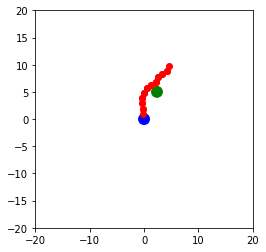

 54%|███████████████████████████████████████▉                                  | 108000/200000 [18:56<17:24, 88.05it/s]

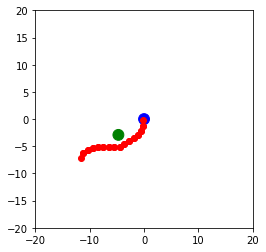

 54%|████████████████████████████████████████▎                                 | 108991/200000 [19:06<16:53, 89.80it/s]

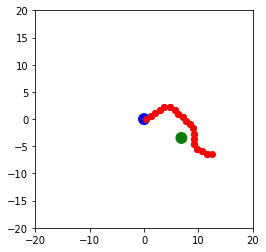

 55%|████████████████████████████████████████▋                                 | 109993/200000 [19:16<15:00, 99.93it/s]

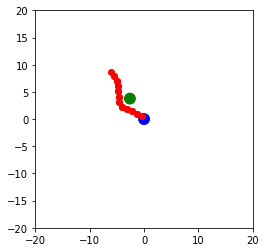

 55%|█████████████████████████████████████████                                 | 110996/200000 [19:27<15:59, 92.72it/s]

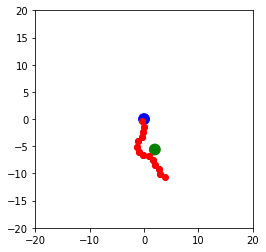

 56%|█████████████████████████████████████████▍                                | 111995/200000 [19:37<14:53, 98.48it/s]

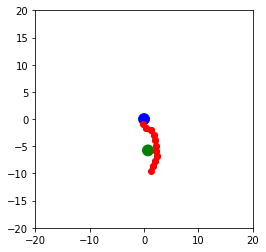

 56%|█████████████████████████████████████████▏                               | 112996/200000 [19:48<14:18, 101.37it/s]

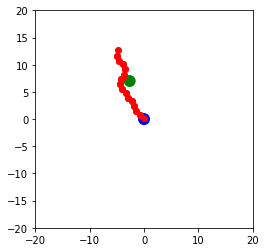

 57%|█████████████████████████████████████████▌                               | 113991/200000 [19:58<14:05, 101.73it/s]

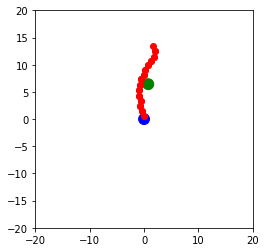

 57%|██████████████████████████████████████████▌                               | 114994/200000 [20:08<14:35, 97.10it/s]

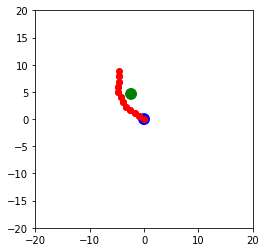

 58%|██████████████████████████████████████████▉                               | 115995/200000 [20:18<14:35, 95.97it/s]

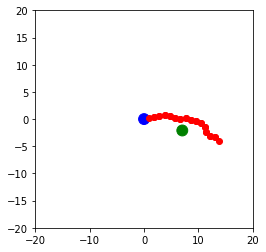

 58%|███████████████████████████████████████████▎                              | 116995/200000 [20:29<14:25, 95.89it/s]

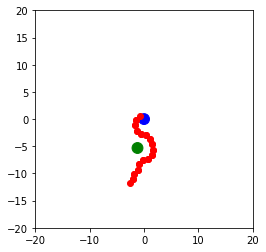

 59%|███████████████████████████████████████████                              | 117997/200000 [20:39<13:02, 104.74it/s]

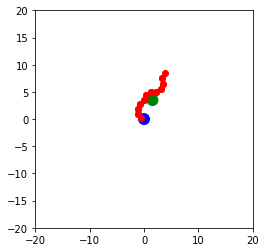

 59%|████████████████████████████████████████████                              | 118998/200000 [20:50<13:39, 98.85it/s]

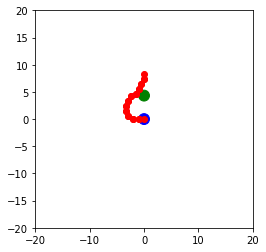

 60%|████████████████████████████████████████████▍                             | 120000/200000 [21:00<13:47, 96.63it/s]

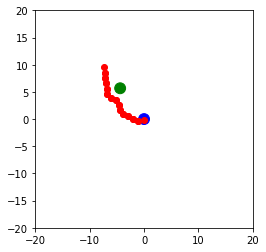

 60%|████████████████████████████████████████████▏                            | 120999/200000 [21:11<13:01, 101.04it/s]

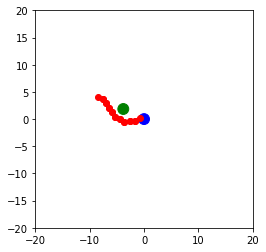

 61%|█████████████████████████████████████████████▏                            | 121992/200000 [21:21<14:05, 92.25it/s]

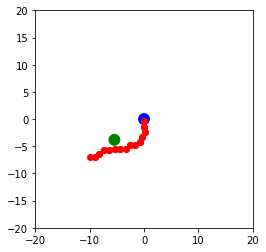

 62%|████████████████████████████████████████████▉                            | 123000/200000 [21:32<12:07, 105.88it/s]

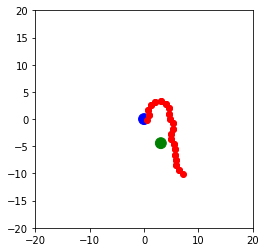

 62%|█████████████████████████████████████████████▎                           | 124000/200000 [21:42<12:37, 100.37it/s]

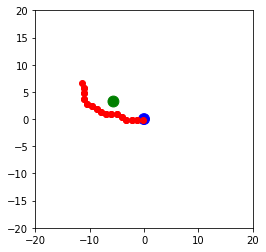

 62%|██████████████████████████████████████████████▏                           | 124990/200000 [21:53<13:40, 91.39it/s]

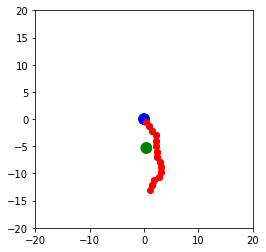

 63%|█████████████████████████████████████████████▉                           | 125994/200000 [22:04<12:18, 100.14it/s]

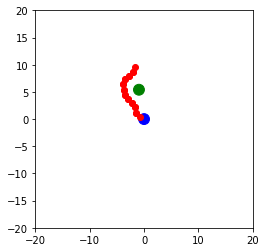

 63%|██████████████████████████████████████████████▉                           | 126993/200000 [22:14<12:27, 97.69it/s]

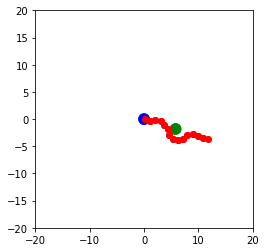

 64%|███████████████████████████████████████████████▎                          | 128000/200000 [22:25<12:24, 96.66it/s]

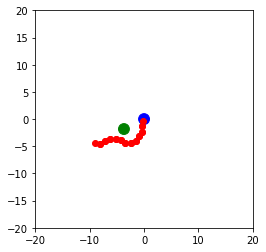

 64%|███████████████████████████████████████████████▋                          | 129000/200000 [22:35<12:26, 95.10it/s]

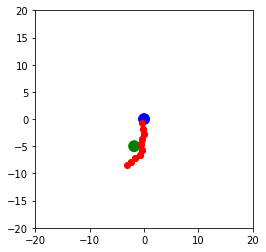

 65%|███████████████████████████████████████████████▍                         | 129995/200000 [22:45<11:11, 104.30it/s]

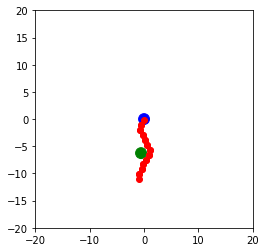

 65%|████████████████████████████████████████████████▍                         | 130989/200000 [22:56<11:37, 99.00it/s]

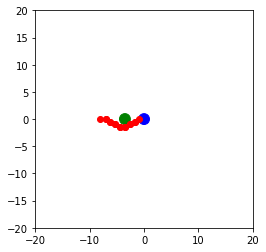

 66%|████████████████████████████████████████████████▏                        | 131993/200000 [23:06<11:08, 101.68it/s]

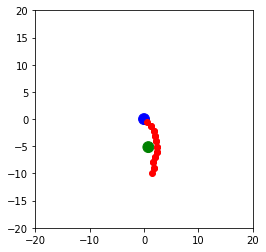

 66%|████████████████████████████████████████████████▌                        | 132994/200000 [23:16<11:00, 101.50it/s]

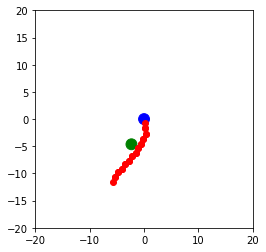

 67%|█████████████████████████████████████████████████▌                        | 133995/200000 [23:27<11:37, 94.67it/s]

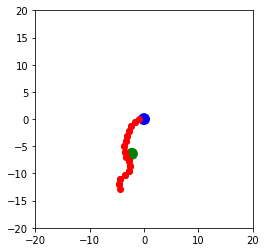

 68%|█████████████████████████████████████████████████▉                        | 135000/200000 [23:37<11:08, 97.28it/s]

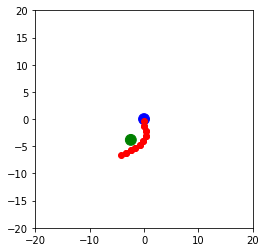

 68%|██████████████████████████████████████████████████▎                       | 135995/200000 [23:47<12:19, 86.59it/s]

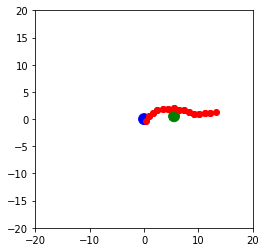

 68%|██████████████████████████████████████████████████▋                       | 136996/200000 [23:58<10:53, 96.37it/s]

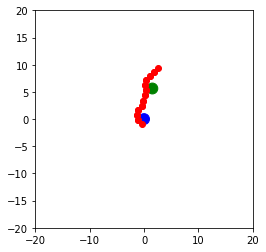

 69%|███████████████████████████████████████████████████                       | 137998/200000 [24:09<11:23, 90.77it/s]

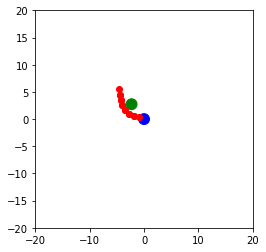

 69%|██████████████████████████████████████████████████▋                      | 138999/200000 [24:20<09:45, 104.19it/s]

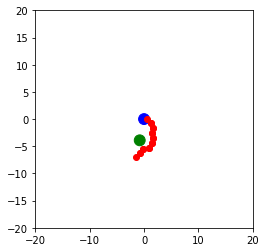

 70%|███████████████████████████████████████████████████▊                      | 140000/200000 [24:30<10:29, 95.30it/s]

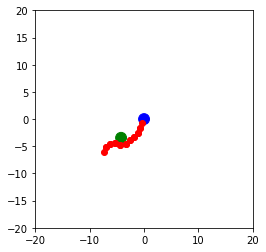

 70%|███████████████████████████████████████████████████▍                     | 140997/200000 [24:40<09:46, 100.68it/s]

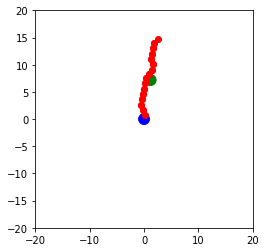

 71%|████████████████████████████████████████████████████▌                     | 141999/200000 [24:51<10:20, 93.52it/s]

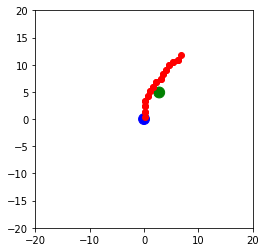

 71%|████████████████████████████████████████████████████▉                     | 142991/200000 [25:01<10:27, 90.87it/s]

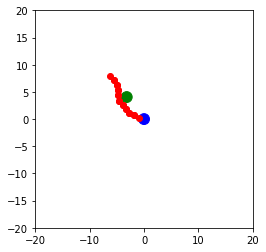

 72%|████████████████████████████████████████████████████▌                    | 143996/200000 [25:12<08:56, 104.33it/s]

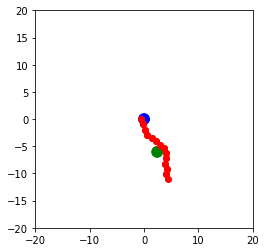

 72%|█████████████████████████████████████████████████████▋                    | 144995/200000 [25:22<10:28, 87.54it/s]

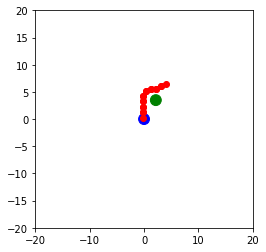

 73%|██████████████████████████████████████████████████████                    | 146000/200000 [25:33<10:10, 88.39it/s]

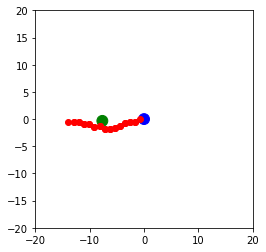

 73%|█████████████████████████████████████████████████████▋                   | 146997/200000 [25:43<08:46, 100.69it/s]

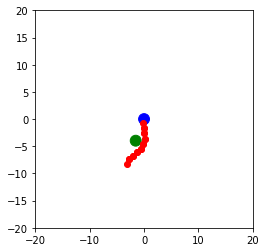

 74%|██████████████████████████████████████████████████████▊                   | 147993/200000 [25:54<08:55, 97.05it/s]

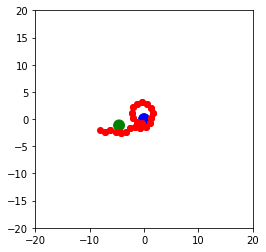

 74%|███████████████████████████████████████████████████████▏                  | 148991/200000 [26:04<08:36, 98.80it/s]

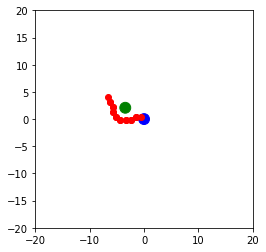

 75%|███████████████████████████████████████████████████████▍                  | 149990/200000 [26:15<08:43, 95.49it/s]

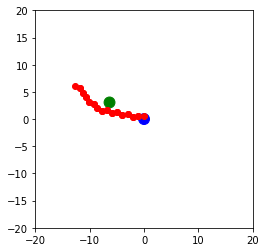

 75%|███████████████████████████████████████████████████████▊                  | 150998/200000 [26:25<08:25, 96.90it/s]

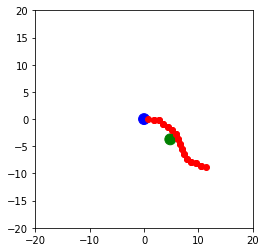

 76%|████████████████████████████████████████████████████████▏                 | 151998/200000 [26:36<08:42, 91.85it/s]

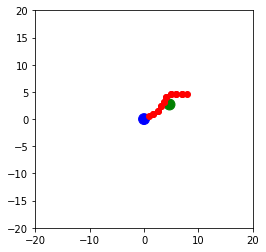

 76%|████████████████████████████████████████████████████████▌                 | 152992/200000 [26:46<07:56, 98.66it/s]

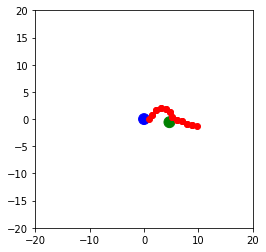

 77%|████████████████████████████████████████████████████████▏                | 153993/200000 [26:57<07:32, 101.77it/s]

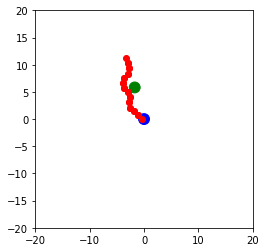

 78%|████████████████████████████████████████████████████████▌                | 155000/200000 [27:07<07:14, 103.53it/s]

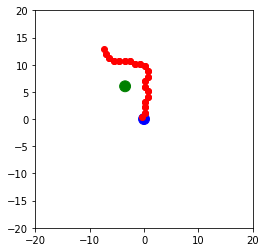

 78%|█████████████████████████████████████████████████████████▋                | 155992/200000 [27:18<08:17, 88.53it/s]

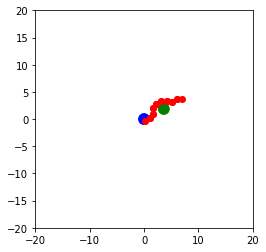

 78%|██████████████████████████████████████████████████████████                | 156996/200000 [27:28<07:28, 95.95it/s]

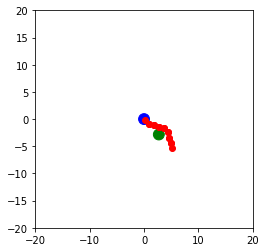

 79%|██████████████████████████████████████████████████████████▍               | 157993/200000 [27:38<07:04, 98.88it/s]

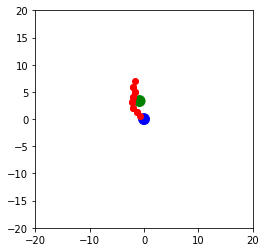

 79%|██████████████████████████████████████████████████████████▊               | 158997/200000 [27:49<06:57, 98.17it/s]

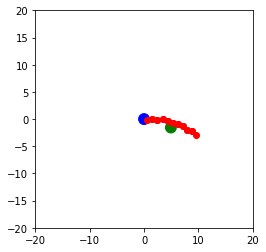

 80%|███████████████████████████████████████████████████████████▏              | 159999/200000 [27:59<06:44, 98.82it/s]

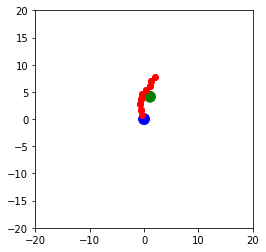

 80%|███████████████████████████████████████████████████████████▌              | 160998/200000 [28:10<07:02, 92.36it/s]

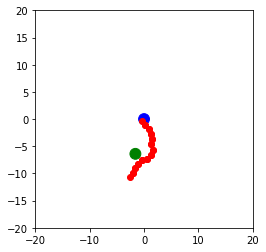

 81%|███████████████████████████████████████████████████████████▉              | 161994/200000 [28:20<06:49, 92.86it/s]

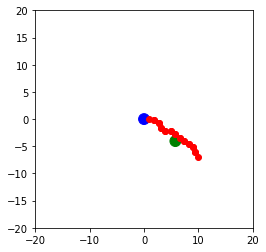

 81%|████████████████████████████████████████████████████████████▎             | 162990/200000 [28:30<07:02, 87.67it/s]

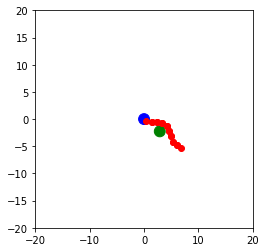

 82%|████████████████████████████████████████████████████████████▋             | 163999/200000 [28:40<06:22, 94.06it/s]

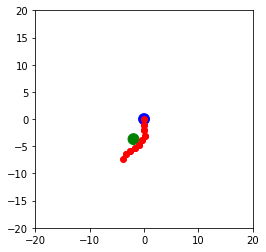

 82%|█████████████████████████████████████████████████████████████             | 164997/200000 [28:51<06:00, 97.15it/s]

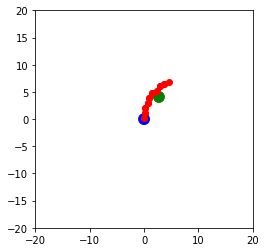

 83%|█████████████████████████████████████████████████████████████▍            | 165991/200000 [29:02<06:05, 93.09it/s]

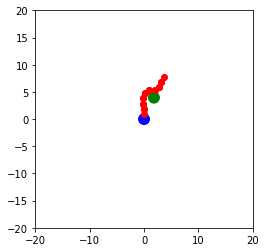

 83%|█████████████████████████████████████████████████████████████▊            | 166999/200000 [29:12<05:39, 97.32it/s]

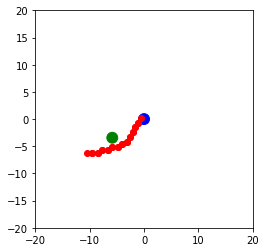

 84%|██████████████████████████████████████████████████████████████▏           | 168000/200000 [29:22<05:33, 96.02it/s]

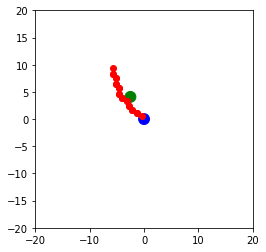

 84%|██████████████████████████████████████████████████████████████▌           | 169000/200000 [29:32<05:27, 94.57it/s]

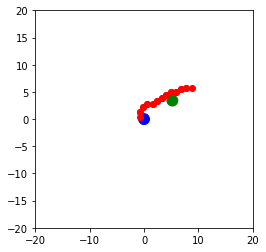

 85%|██████████████████████████████████████████████████████████████▉           | 169992/200000 [29:42<05:08, 97.41it/s]

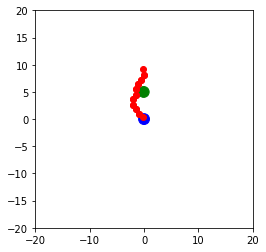

 85%|███████████████████████████████████████████████████████████████▎          | 170993/200000 [29:53<05:23, 89.59it/s]

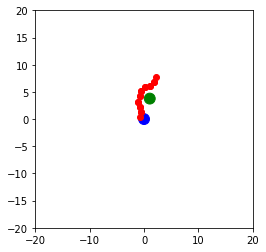

 86%|██████████████████████████████████████████████████████████████▊          | 171991/200000 [30:03<04:31, 103.02it/s]

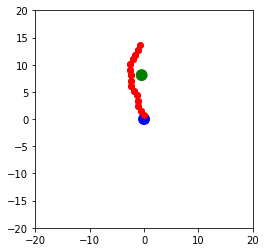

 86%|████████████████████████████████████████████████████████████████          | 172997/200000 [30:14<04:45, 94.44it/s]

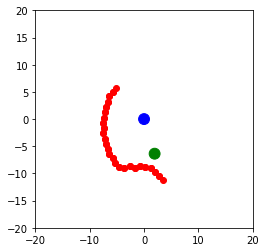

 87%|████████████████████████████████████████████████████████████████▍         | 174000/200000 [30:24<04:25, 97.93it/s]

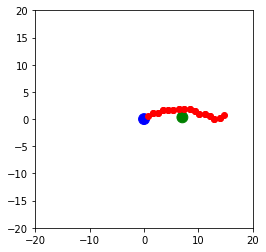

 87%|███████████████████████████████████████████████████████████████▊         | 174991/200000 [30:34<04:10, 100.02it/s]

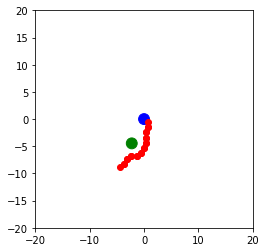

 88%|█████████████████████████████████████████████████████████████████         | 175998/200000 [30:44<04:06, 97.41it/s]

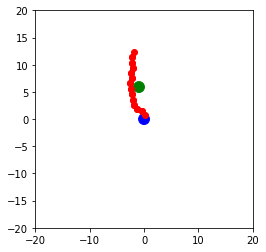

 88%|█████████████████████████████████████████████████████████████████▍        | 176991/200000 [30:55<04:08, 92.75it/s]

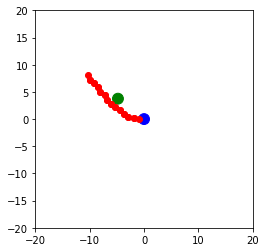

 89%|█████████████████████████████████████████████████████████████████▊        | 177999/200000 [31:05<03:49, 96.02it/s]

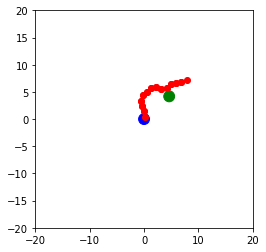

 89%|██████████████████████████████████████████████████████████████████▏       | 178998/200000 [31:16<03:55, 89.30it/s]

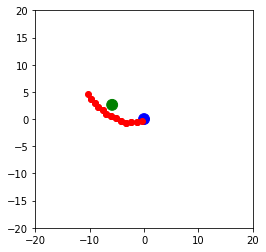

 90%|██████████████████████████████████████████████████████████████████▌       | 179996/200000 [31:27<03:34, 93.38it/s]

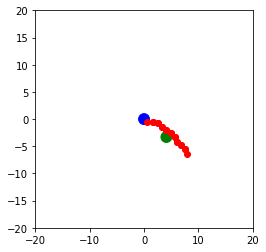

 90%|██████████████████████████████████████████████████████████████████▉       | 180996/200000 [31:37<03:29, 90.65it/s]

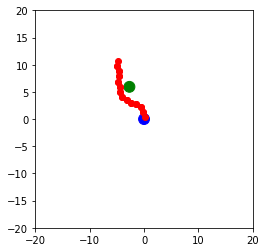

 91%|███████████████████████████████████████████████████████████████████▎      | 181998/200000 [31:48<03:13, 92.99it/s]

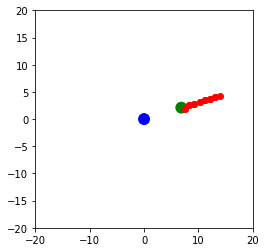

 91%|███████████████████████████████████████████████████████████████████▋      | 182999/200000 [31:58<03:22, 83.84it/s]

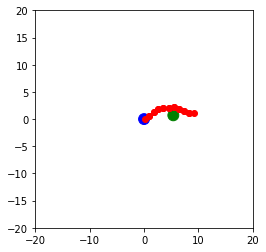

 92%|████████████████████████████████████████████████████████████████████      | 183996/200000 [32:09<02:48, 95.07it/s]

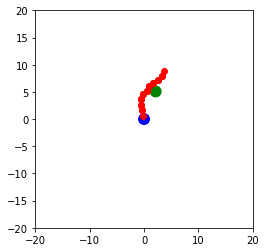

 92%|████████████████████████████████████████████████████████████████████▍     | 184997/200000 [32:19<02:38, 94.76it/s]

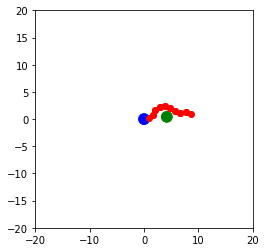

 93%|████████████████████████████████████████████████████████████████████▊     | 185992/200000 [32:29<02:22, 98.35it/s]

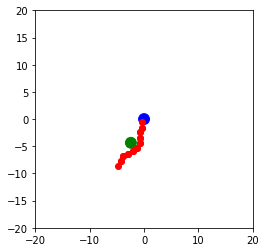

 93%|████████████████████████████████████████████████████████████████████▎    | 186998/200000 [32:40<02:08, 100.89it/s]

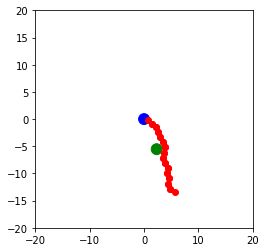

 94%|█████████████████████████████████████████████████████████████████████▌    | 187991/200000 [32:50<02:13, 90.24it/s]

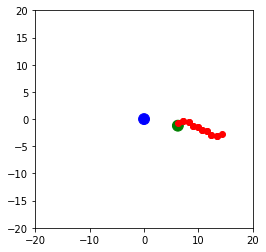

 94%|█████████████████████████████████████████████████████████████████████▉    | 188993/200000 [33:01<01:57, 93.61it/s]

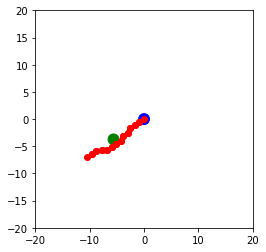

 95%|██████████████████████████████████████████████████████████████████████▎   | 189997/200000 [33:12<01:50, 90.61it/s]

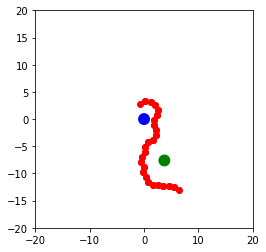

 95%|██████████████████████████████████████████████████████████████████████▋   | 190997/200000 [33:22<01:36, 92.94it/s]

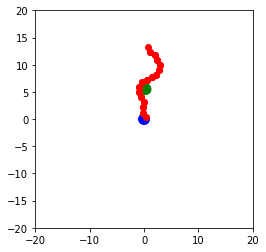

 96%|██████████████████████████████████████████████████████████████████████   | 191994/200000 [33:33<01:19, 100.15it/s]

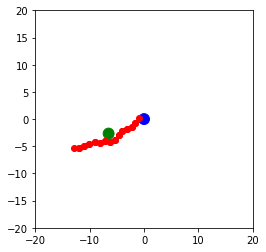

 96%|██████████████████████████████████████████████████████████████████████▍  | 192995/200000 [33:43<01:07, 103.65it/s]

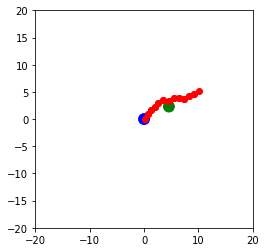

 97%|██████████████████████████████████████████████████████████████████████▊  | 193999/200000 [33:53<00:56, 106.35it/s]

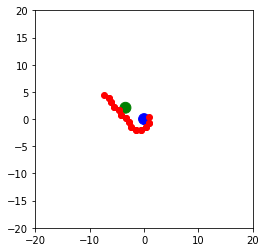

 97%|███████████████████████████████████████████████████████████████████████▏ | 194996/200000 [34:04<00:48, 103.43it/s]

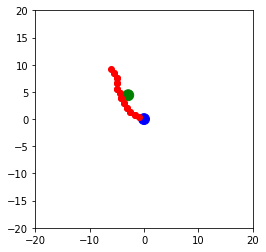

 98%|████████████████████████████████████████████████████████████████████████▌ | 195994/200000 [34:15<00:42, 95.36it/s]

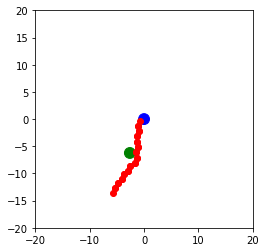

 98%|████████████████████████████████████████████████████████████████████████▉ | 196990/200000 [34:25<00:32, 94.02it/s]

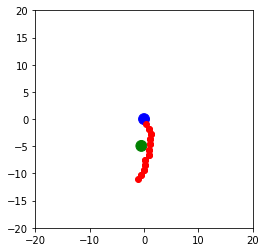

 99%|████████████████████████████████████████████████████████████████████████▎| 197997/200000 [34:36<00:19, 103.24it/s]

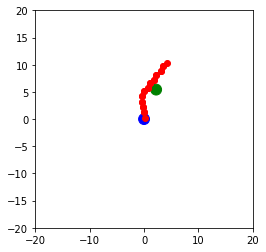

 99%|████████████████████████████████████████████████████████████████████████▋| 198990/200000 [34:46<00:09, 106.60it/s]

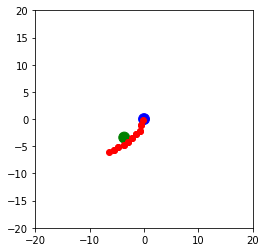

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [34:57<00:00, 95.36it/s]


In [263]:
rewards = []
net = DQN()

def main():
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # reward = reward * 100 if reward > 0 else reward * 5
            sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                # print("episode {}, the reward is {}".format(episode, round(reward, 3)))
                rewards.append(sum_rew)
                if episode % 1000 == 0:
                    env.draw_map()
                # net.plot(net.ax, step_counter_list)
                break

            state = next_state
            

if __name__ == '__main__':
    main()

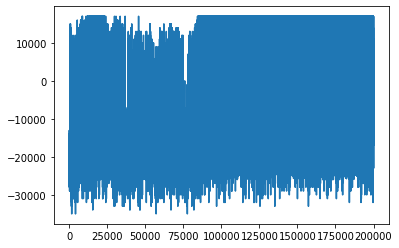

In [254]:
plt.plot(rewards)

In [255]:
m = 0
p = 0
for i in rewards:
    if i < 0:
        m += 1
    else:
        p += 1

In [256]:
m / (m + p)

0.417895

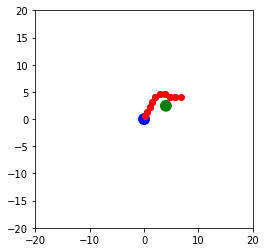

In [219]:
env.draw_map()

In [ ]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        print(self.actions)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )